## Optimal Transport to match cafes and bakeries

In [13]:
import folium
from geopy.geocoders import Nominatim
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import geopy.distance
import cvxpy as cp

In [12]:
G_walk = ox.graph_from_place('Paris, France',
                             network_type='walk')

In [14]:
G_walk

In [15]:
cafes = pd.read_csv("data_geo/cafes.csv", sep=";").dropna(subset=["lat", "lon"])
bakeries = pd.read_csv("data_geo/boulangeries.csv",sep=";").dropna(subset=["lat", "lon"])

In [16]:
bakeries.head()

,id,name,website,lat,lon
0,690288259,Atelier Huré,https://linktr.ee/Atelierhure,48.844370,2.354997
1,690288265,L'Escale Douceur,NaN,48.846564,2.354182
2,702473077,Maison Gaumer,NaN,48.846266,2.351969
3,703619122,Philippe Teillet,NaN,48.843683,2.352107
4,845181895,Boulangerie Attos,NaN,48.837750,2.354132


In [17]:
cafes.head()

,id,name,website,lat,lon
0,262934233,Le Nouvel Institut,NaN,48.849205,2.355665
1,315785934,Pub Gay-Lussac,NaN,48.841516,2.343644
2,320952623,Le Reflet,NaN,48.849738,2.342828
3,321932192,Café Panis,https://www.cafepanis.com/,48.852201,2.348372
4,447033603,Le Duc,NaN,48.847640,2.342426


In [18]:
n = len(bakeries)
m = len(cafes)
print("number of bakeries :", n)
print("number of cafes :", m)

number of bakeries : 46
number of cafes : 121


In [19]:
k = min(n, m)
n = k
m = k
bakeries = bakeries[:k]
cafes = cafes[:k]

In [20]:
C = np.zeros((n, m))

In [21]:
cafes.iloc[0]["lat"]

48.8492048

In [22]:
geopy.distance.geodesic((48.849205, 2.355665), (48.841516, 2.343644)).km

1.2286689421436752

In [23]:
X = np.zeros((k, 2))
Y = np.zeros((k, 2))

In [24]:
start = time()
for i in range(n) :
    for j in range(m) :
        c1 = (cafes.iloc[j]["lat"], cafes.iloc[j]["lon"])
        X[j, 0], X[j, 1] = cafes.iloc[j]["lat"], cafes.iloc[j]["lon"]
        c2 = (bakeries.iloc[i]["lat"], bakeries.iloc[i]["lon"])
        Y[i, 0], Y[i, 1] = bakeries.iloc[i]["lat"], bakeries.iloc[i]["lon"]
        C[i, j] = geopy.distance.geodesic(c1, c2).km
end = time()

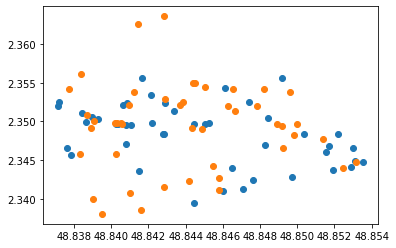

In [25]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(Y[:,0], Y[:,1])
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.show()

In [26]:
print("Running Time : {:.2f} s".format(end-start))

Running Time : 2.26 s


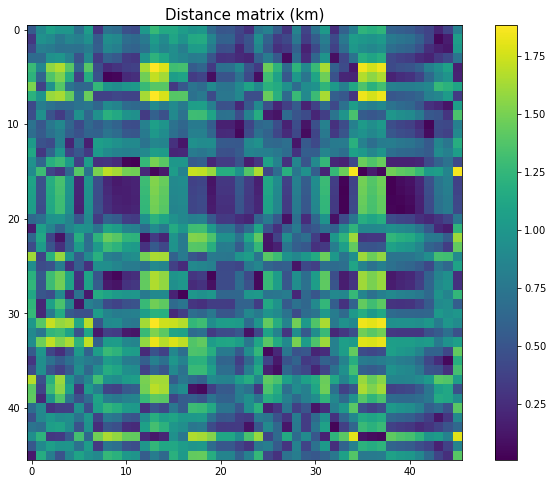

In [27]:
fig = plt.figure(figsize=(12, 8))
plt.title("Distance matrix (km)", fontsize=15)
plt.imshow(C)
plt.colorbar()
plt.show()

In [28]:
n = k
m = k
a = np.ones(n)/n
b = np.ones(m)/m
P = cp.Variable((n,m))

In [29]:
u = np.ones(m)
v = np.ones(n)
U = [0 <= P, cp.matmul(P,u)==a, cp.matmul(P.T,v)==b]

In [30]:
objective = cp.Minimize( cp.sum(cp.multiply(P,C)) )
prob = cp.Problem(objective, U)
result = prob.solve(solver=cp.ECOS)

In [31]:
print("Number of non-zero: %d (n + m-1 = %d)" %(len(P.value[P.value>1e-3]), n))

Number of non-zero: 46 (n + m-1 = 46)


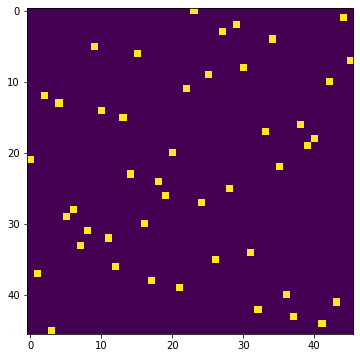

In [32]:
fig = plt.figure(figsize=(10, 6))
plt.imshow(P.value)
plt.show()

In [33]:
P.value>1e-3

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [34]:
x = np.where(P.value[i,:]>1e-3)
x[0][0]

3

In [35]:
routes = []

In [36]:
caf = cafes[["lat", "lon"]].values
bak = bakeries[["lat", "lon"]].values

In [37]:
caf.shape

(46, 2)

In [114]:
routes = []
paths = []

In [115]:
for i in range(k):
    j = np.where(P.value[i,:]>1e-3)[0][0]
    c1 = (bak[i, 0], bak[i, 1]) 
    c2 = (caf[j, 0], caf[j, 1])
    start_node = ox.distance.nearest_nodes(G_walk, bak[i, 1], bak[i, 0])
    end_node = ox.distance.nearest_nodes(G_walk, caf[j, 1], caf[j, 0])
    
    #end_node = end_node[0]
    route = ox.shortest_path(G_walk, start_node, end_node, weight='length')
    
    route_coordinates = [(G_walk.nodes[node]['y'], G_walk.nodes[node]['x']) for node in route]
    paths.append(route)
    routes.append(route_coordinates)

In [66]:
i = 0
j = np.where(P.value[i,:]>1e-3)[0][0]
c1 = (bak[i, 0], bak[i, 1]) 
c2 = (caf[j, 0], caf[j, 1])

In [99]:
for i in range(k):
    j = np.where(P.value[i,:]>1e-3)[0][0]
    c1 = (bak[i, 0], bak[i, 1]) 
    c2 = (caf[j, 0], caf[j, 1])
    routes2.append([c1]+routes[i]+[c2])

In [110]:
i = 0
j = np.where(P.value[i,:]>1e-3)[0][0]
c1 = (bak[i, 0], bak[i, 1]) 
c2 = (caf[j, 0], caf[j, 1])
start_node = ox.distance.nearest_nodes(G_walk, bak[i, 1], bak[i, 0])
end_node = ox.distance.nearest_nodes(G_walk, caf[j, 1], caf[j, 0])

#end_node = end_node[0]
route = ox.shortest_path(G_walk, start_node, end_node, weight='length')

route_coordinates = [(G_walk.nodes[node]['y'], G_walk.nodes[node]['x']) for node in route]

In [20]:
# Find the nearest nodes to the start and end locations
start_node = ox.distance.nearest_nodes(G_walk, start_location.longitude, start_location.latitude)
end_node = ox.distance.nearest_nodes(G_walk, end_location.longitude, end_location.latitude)
print(start_node, end_node)

11039514718 11037655805


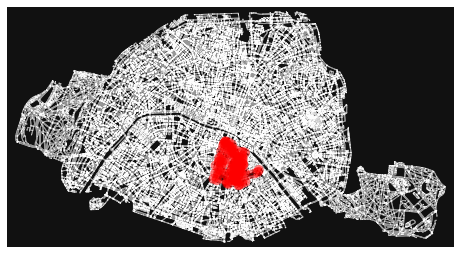

<Figure size 432x288 with 0 Axes>

In [117]:
fig, ax = ox.plot_graph_routes(G_walk,
                              paths,
                              node_size=1,
                              save=True,
                              )
plt.savefig("optimal_matching.png")

In [107]:
G_walk?

In [233]:
start_address = "15 rue des Gobelins, Paris, France"
end_address = "23 Rue des Écoles, Paris, France"

geolocator = Nominatim(user_agent="driving_distance_calculator")
start_location = geolocator.geocode(start_address)
end_location = geolocator.geocode(end_address)

In [234]:
end_location.latitude, end_location.longitude

(48.8483619, 2.3489766)

In [255]:
float(cafes.iloc[0]["lat"])

48.8492048

In [298]:
routes

[[(48.8447215, 2.3548517),
  (48.8447151, 2.3547562),
  (48.8439845, 2.3548856),
  (48.8439734, 2.3547743),
  (48.8437241, 2.3548175),
  (48.843701, 2.3547937),
  (48.8436982, 2.3543025),
  (48.8436661, 2.3543056),
  (48.8436106, 2.354321),
  (48.8435887, 2.3542895),
  (48.84279, 2.3544665),
  (48.8427838, 2.354399),
  (48.8427755, 2.3543092),
  (48.8424674, 2.3543767),
  (48.842441, 2.3543579),
  (48.8424114, 2.3536599),
  (48.8423764, 2.3536853),
  (48.8423742, 2.3535862),
  (48.842243, 2.3536228),
  (48.842241, 2.3535503),
  (48.8421974, 2.3535646)],
 [(48.8469153, 2.3544595),
  (48.8469952, 2.3544601),
  (48.8470214, 2.3545015),
  (48.8471557, 2.3547135),
  (48.8472333, 2.354836),
  (48.8472333, 2.3549553),
  (48.8473133, 2.3549559),
  (48.8474263, 2.3551331),
  (48.847557, 2.3553311),
  (48.8475311, 2.3553903),
  (48.8476363, 2.3554521),
  (48.847824, 2.3557403),
  (48.8479571, 2.3555489),
  (48.8474636, 2.3562607),
  (48.8471614, 2.3558017),
  (48.8473047, 2.3555957),
  (48.84748

In [135]:
map_center = (cafes.iloc[0]["lat"], cafes.iloc[0]["lon"])
my_map = folium.Map(location=map_center, zoom_start=15)

# Plot start and end markers

for i in range(k) :
    #folium.Marker(location=(bakeries.iloc[i]["lat"], bakeries.iloc[i]["lon"]), popup=str(bakeries.iloc[i]["name"])+ ": "+"red").add_to(my_map)
    dot_marker = folium.Marker(location=(bakeries.iloc[i]["lat"], bakeries.iloc[i]["lon"]), popup =str(bakeries.iloc[i]["name"]),  icon=folium.Icon(color='blue', icon="times"))
    my_map.add_child(dot_marker)
for i in range(k) :
    #folium.Marker(location=(cafes.iloc[i]["lat"], cafes.iloc[i]["lon"]), popup=str(cafes.iloc[i]["name"])+ ": "+"blue").add_to(my_map)
    x_marker = folium.Marker(location=(cafes.iloc[i]["lat"], cafes.iloc[i]["lon"]), popup =str(cafes.iloc[i]["name"]), icon=folium.Icon(color='red', icon='times'))
    my_map.add_child(x_marker)
#folium.Marker(location=(end_location.latitude, end_location.longitude), popup='End').add_to(my_map)

for route in routes :
    if route :
        folium.PolyLine(locations=route, color='red', weight=5, opacity=0.7).add_to(my_map)


In [140]:
my_map

In [138]:
my_map.save('optimal_matching.html')

In [139]:
pwd

'/home/simon/Documents/Études/3A_ENS_Paris_Saclay/MVA/S1/Computational Optimal transport/numerics'

In [34]:
#distance = sum(ox.utils_graph.get_route_edge_attributes(G_walk, route, 'length'))